In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
dataset_path = os.path.join('../assets', 'sword')
np.set_printoptions(precision=4, suppress=True)

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread(os.path.join(dataset_path, 'lsword1.jpg'),cv.IMREAD_GRAYSCALE)     # queryImage
img2 = cv.imread(os.path.join(dataset_path, 'lsword3.jpg'),cv.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

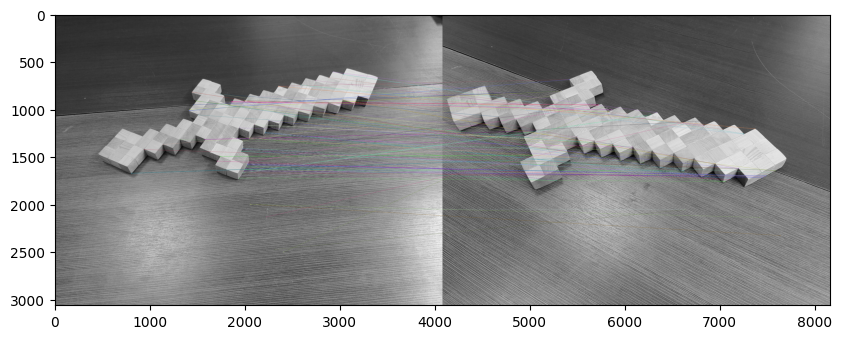

In [4]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10,24))
plt.imshow(img3)
plt.show()

(array([ 8., 14.,  9., 15., 21., 16., 14.,  2.,  4.,  4.]),
 array([24. , 30.1, 36.2, 42.3, 48.4, 54.5, 60.6, 66.7, 72.8, 78.9, 85. ]),
 <BarContainer object of 10 artists>)

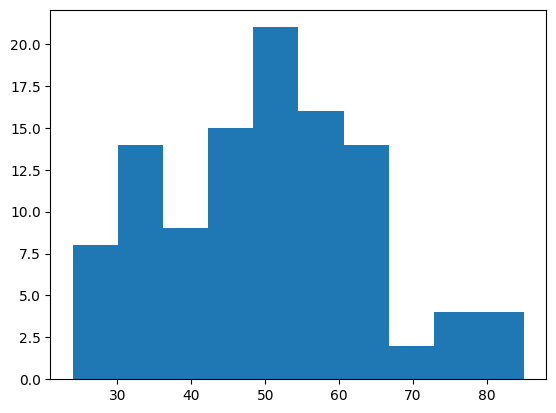

In [5]:
distances = [match.distance for match in matches]

_, bins = np.histogram(distances)
plt.hist(distances, bins)

In [6]:
# как добраться непосредственно до точек на изображениях

print(kp1[matches[0].queryIdx].pt)
print(kp2[matches[0].trainIdx].pt)

(3033.760498046875, 633.02880859375)
(3174.69921875, 1257.69677734375)


In [7]:
def matches_to_points(matches, kp1):
    points = []
    for match in matches:
        x1, y1 = kp1[match.queryIdx].pt
        x2, y2 = kp1[match.trainIdx].pt
        points.append((x1, y1, x2, y2))
    return np.array(points)


def gen_equation(p):
    x1, y1, x2, y2 = p
    return np.array([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])


def gen_F_equation(matches, keypoints):
    points = matches_to_points(matches, keypoints)
    return np.apply_along_axis(gen_equation, 1, points)

In [8]:
F_system = gen_F_equation(matches, kp1)

In [9]:
U, S, V = np.linalg.svd(F_system)

In [10]:
np.set_printoptions(precision=8, suppress=True)
F = V[:,8].reshape((3,3))
print(F)

[[-0.00000016  0.00000002 -0.00000003]
 [ 0.0000004  -0.00050533  0.00029469]
 [-0.00000224 -0.00008104 -0.99999983]]


In [14]:
U, S, V = np.linalg.svd(F)
print(S)
U @ np.diag(S) @ V

[0.99999987 0.00050535 0.00000016]


array([[-0.00000016,  0.00000002, -0.00000003],
       [ 0.0000004 , -0.00050533,  0.00029469],
       [-0.00000224, -0.00008104, -0.99999983]])

In [16]:
U, S, V = np.linalg.svd(F)
S[2] = 0

In [26]:
F_refined = U @ np.diag(S) @ V
print(F_refined)
print(np.linalg.matrix_rank(F_refined))

[[-2190424.06434532 -3528348.21844738    -1480.00460054]
 [-3526591.83375465 -5685775.29572089    -2382.81617694]
 [   -1480.01140094    -2384.01135741       -0.99999983]]
2


In [19]:
K = np.array([[3.07572420e+03, 0.00000000e+00, 1.48000478e+03],
              [0.00000000e+00, 3.18098248e+03, 2.38375400e+03],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [25]:
E = K.T @ F_refined @ K
print(E)

[[   -0.00013255     0.17352961     0.12989663]
 [    3.89588802 -5113.23500877 -3828.92686428]
 [    2.91254471 -3831.91320282 -2870.44236743]]


In [24]:
U, S, V = np.linalg.svd(E)
print(S)

[7874776.38549368    1424.17040844       0.        ]


In [27]:
W = np.array([[0, -1, 0],
              [1,  0, 0],
              [0,  0, 1]])

In [41]:
def gen_possible_camera_pose(U1, U2, W, V, tolerance=1e-4):
    C = U1[:, 2]
    R = U2 @ W @ V
    if abs(int(np.linalg.det(R)) + 1) < tolerance:
        return -C, -R
    else:
        return C, R


In [43]:
C1, R1 = gen_possible_camera_pose(U, U, W, V.T)
C2, R2 = gen_possible_camera_pose(-U, U, W, V.T)
C3, R3 = gen_possible_camera_pose(-U, U, W.T, V.T)
C4, R4 = gen_possible_camera_pose(-U, U, W.T, V.T)

[ 0.00067564  0.00000002 -0.99999977] [[-0.89605255  0.44394624 -0.00124927]
 [-0.44394695 -0.896053    0.00035544]
 [-0.00096162  0.0008731   0.99999916]]


переход между пиксельными и нормализованными координатами

https://opensfm.readthedocs.io/en/latest/geometry.html